# Thesis Project

## Requirements and Imports

All requirements in this project are managed by `Pipenv` and are denoted in the `Pipfile`, which can be found in the same directory.

In [1]:
# Basic imports
import os
import re
import math
import glob
import wfdb
import time
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wfdb import processing
from functools import partial

# PyTorch related imports
import torch
import torchinfo
import torch.nn as nn
import torch.jit as jit
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# RayTune related imports
from ray import tune, put, get, ray
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# Sklearn and Scipy related imports
from scipy import signal
from statsmodels.tsa.stattools import ccf
from skimage.restoration import denoise_wavelet
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Configuration

This the following code cell can be used to configure certain aspects of the project regarding random number generation, graphics card utilization, model and data loading, noise models and training.
To specify offsets (for instance for the sampling rate or the segment size), please refer to the official [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).

In [2]:
# Set a random seed for pytorch (always split the data the same way), for the random package and for numpy. Required for reproducability.
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# If a GPU (Cuda) is available, it will be used to train and test the machine learning models.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# The directory for saving and loading the trained models.
model_directory = './models/'

# Here, some basic settings for the datasets and are set.
data_directory = './data/'
sampling_rate = '10L' # 10ms, The signal will be resampled based on this sampling rate.
segment_size = '10240L' # 10240 ms, The signal will be split based on this length.
window_size = 1024
step_size = 128
segment_size_samples = int(pd.to_timedelta(segment_size).total_seconds() / pd.to_timedelta(sampling_rate).total_seconds())
train_split = 0.8

# The target noise SNR values for training and testing.
train_target_snr_dbs = [-2.5, 0, 2.5, 47.5, 50, 52.5] # dB
test_target_snr_dbs =  [-5, -1, 0, 3, 6, 9] # dB

# Number of epochs for training.
num_epochs = 128

## Dataset

This is a utility class which is used to manage the required data and for adding and generating noise to the data samples. It inherits from the PyTorch `Dataset` class, which provides tools like splitting the data into train, validation and test subsets or using it in dataloaders to efficiently access the data in batches while training and testing. The dataset for this experiment coprises the [CEBS](https://physionet.org/content/cebsdb/1.0.0/) dataset, the [IEEE](https://ieee-dataport.org/documents/mechanocardiograms-ecg-reference) dataset and another dataset, called [D2](https://zenodo.org/record/5279448). Either SCG and ECG samples can be used as x and y values or SCG and noisy SCG samples. The data from the denoted datasets will be loaded directly when initialising an object of the class. Each dataset will be imported, depending on its specific characteristics, the schemas will be normalized, the dataset will be resampled and each dataset will be splitted into windows with a size of `segment_size_samples` and an offset of 128. Subsequelty, all datasets will be combined. Noise will only be added if the y samples are from an SCG signal. However, initially no noise will be added to the data, i.e. the clean and noisy data will be the same in the beginning. This is done so that training and testing can be done with different noise levels. The noise generated is gaussian white noise and/or from a second noise model that which focusses on motion noise. The two noise models can be used independently or together, with a certain probalility in generating WGN. The motion focussed noise model apopts noise data from a dataset which comprises [data from a chest-worn accelerometer](https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer) while doing 7 different activities. The gravity component will be removed from the data as it is already present in the SCG datasets. To model the noise, `segment_size_samples` long consequtive samples will be extracted and added to the y-samples. Please note that the code for generating the WGN noise was adopted from [this](https://stackoverflow.com/a/53688043) example.

In [3]:
# Method to normalize the input data between -1 and 1. Returns the minimum and maximum values of the original signal aswell for later denormalization.
def normalize(data):
    data_concat = np.concatenate(data) if data[0].ndim == 1 else data
    min_val = np.min(data_concat)
    max_val = np.max(data_concat)
    data_norm = 2 * (data - min_val) / (max_val - min_val) - 1
    return data_norm, min_val, max_val

# Denormalizes the input data to its original form, given the minimum and maximum values of the original signal.
def denormalize(data, min_val, max_val):
    data_denorm = (max_val * data + max_val - data * min_val + min_val) / 2
    return data_denorm

# A butter bandpass filter for the input signal with the order, frequency-space, lowcut (Hz) and highcut (Hz) as arguments. Returns the filtered signal.
def bandpass(input_signal, order=4, fs=100.0, lowcut=5.0, highcut=30.0):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    b, a, = signal.butter(order, [low, high], 'bandpass', analog=False)
    y = signal.filtfilt(b, a, input_signal, axis=0)

    return y

In [4]:
class SCGData(Dataset):

    '''
    A dataset class to manage all the different datasets being used in this project.

    :param directory: The directory where the datasets (each in their own directory) are located.
    :param datasets: A list of strings 'CEBS', 'D2' and 'IEEE' of the datasets that should be loaded.
    :param transform: The transformation that will be applied to the data samples when they are accessed.
    :param ecg: If true, the y_data samples will be ecg data and otherwise the noisy SCG samples.
    '''
    def __init__(self, directory=None, datasets=None, transform=None, ecg=False, is_bandpass=False):

        self.directory = directory
        self.datasets = datasets
        self.transform = transform
        self.min_val = None
        self.max_val = None
        self.data_noise = None
        self.ecg = ecg
        self.is_bandpass = is_bandpass

        self.__load_noise_data()

        data = self.__load_datasets()
        
        # A bandpass filter will be applied on the SCG data, if ecg data is being loaded.
        if self.ecg:
            data['SCG'] = data['SCG'].apply(lambda x: bandpass(x))
        
        # The y values are either ECG samples (when ecg=True) or SCG samples (when ecg=False). Noise will be added later.
        if self.ecg:
            self.x_data = data.SCG.values
            self.y_data = data.ECG.values
        else:
            self.x_data = data.SCG.values
            self.y_data = data.SCG.values

        self.n_samples = data.shape[0]

    '''
    The function may be called to add noise to the x values when no ECG samples were loaded. The values will be randomly sampled from this list.

    :param target_snr_dbs: A list of SNR values to be added with the WGN model. 
    :param noise_model: This parameter can either be 'WGN' for the White Gaussian Noise Model, 'MOTION' for the motion noise model or 'BOTH' for both noise models to be added to the dataset.
    :param wgn_prob: Determines the probability with what the WGN model will be added to the dataset if 'BOTH' was chosen as the noise model.
    '''
    def add_noise(self, target_snr_dbs, noise_model='WGN', wgn_prob=0.33):

        if not self.ecg:
            if noise_model == 'WGN':
                data_noise = np.array([self.__add_gaussian(inputs, target_snr_dbs) for inputs in self.y_data])
            elif noise_model == 'MOTION':
                data_noise = np.array([self.__add_motion(inputs) for inputs in self.y_data])
            elif noise_model == 'BOTH':
                data_noise = np.array([self.__add_gaussian(inputs, target_snr_dbs) if random.random() < wgn_prob else self.__add_motion(inputs) for inputs in self.y_data])
            
            self.x_data, self.min_val, self.max_val = normalize(data_noise)

            if self.is_bandpass:
                self.x_data = np.array([bandpass(inputs) for inputs in self.x_data])

    '''
    A function to add motion noise to 1024 samples long inputs.

    :param data: The data, to which the noise should be added.
    '''
    def __add_motion(self, data):
        
        # Randomly select 1024 consecutive samples from the processed noise dataset.
        rows = range(self.data_noise.shape[0])
        index_start = random.randint(rows.start, rows.stop - window_size)
        noise = self.data_noise.iloc[index_start:index_start + window_size]

        data_noisy = data + 0.025 * noise
        return data_noisy

    '''
    A function to add WGN noise to the inputs.

    :param data: The data, to which the noise should be added.
    :param target_snr_dbs: A list of SNR values to be added. 
    '''
    def __add_gaussian(self, data, target_snr_dbs):

        # target_snr_db = random.choices(target_snr_dbs, weights=target_snr_weights, k=1)[0]
        target_snr_db = random.choice(target_snr_dbs)
        # target_snr_db = random.uniform(-1, 20) # sample from bigger range provides better results?
        # target_snr_db = 1

        data_watts = data ** 2
        data_avg_watts = np.mean(data_watts)
        data_avg_db = 10 * np.log10(data_avg_watts)

        noise_avg_db = data_avg_db - target_snr_db
        noise_avg_watts = 10 ** (noise_avg_db / 10)

        mean_noise = 0
        noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(data_watts))

        data_noisy = data + noise
        return data_noisy

    '''
    Loads the motion noise dataset, upsamples and normalizes it.
    '''
    def __load_noise_data(self):
        data = pd.DataFrame()

        for i in range(1, 16):
            rel_path = os.path.join('NOISE_ACC', f'{i}.csv')
            df = pd.read_csv(os.path.join(self.directory, rel_path), header=None, usecols=[3, 4], names=['Z', 'labels'])
            
            df_resample = pd.DataFrame()

            # Upsample the z-axis data, subtract the mean (gravity compoment) and normalize it 
            df_resample['Z'] = processing.resample_sig(df['Z'], 52, 100)[0]
            # Remove the gravity component from the acceleration data
            df_resample['Z'] = df_resample['Z'] - df_resample['Z'].mean()
            df_resample['Z'], _, _ = normalize(df_resample['Z'])

            # Upsample the labels, round them and prevent values larger than 7 and smaller than 1.
            df_resample['labels'] = processing.resample_sig(df['labels'], 52, 100)[0]
            df_resample['labels'] = df_resample['labels'].round(decimals = 0)
            df_resample.loc[df_resample['labels'] > 7, 'labels'] = 7
            df_resample.loc[df_resample['labels'] < 1, 'labels'] = 1

            data = pd.concat((data, df_resample))

        # The different activities in the dataset.
            # 1: Working at Computer
            # 2: Standing Up, Walking and Going up\down stairs
            # 3: Standing
            # 4: Walking
            # 5: Going Up\Down Stairs
            # 6: Walking and Talking with Someone
            # 7: Talking while Standing

        # Here it is possible to only allow certain activities in the noise dataset.
        # data = data.loc[data['labels'] == 4, 'Z']
        self.data_noise = data['Z']

    
    '''
    Loads one file of the CEBS dataset and processes it. This includes resampling and splitting into groups of 1024 samples.

    :param filename: The name of the specific file to be loaded.
    '''
    def __load_cebs(self, filename):
        
        # Using WFDB to import the files.
        record = wfdb.rdsamp(filename)
        data = record[0]
        metadata = record[1]

        frequency = metadata['fs']
        column_names = metadata['sig_name']
        length = metadata['sig_len']

        data = pd.DataFrame(data, columns=column_names)
        data.drop(['II', 'RESP'], axis=1, inplace=True)
        data.rename(columns={'I': 'ECG'}, inplace=True)

        # Create a datetime index, as it is not given in the dataset. Required for resampling and splitting the data.
        frequency_string = str(int(1/frequency*1000000)) + 'U'
        index = pd.date_range(start='1/1/1970', periods=length, freq=frequency_string)
        data.set_index(index, inplace=True)

        # Resample the data into the desired sampling rate.
        data = data.resample(sampling_rate).mean()

        # Split the data into groups with segment_size_samples samples.
        data = pd.DataFrame([[x.ECG.to_numpy(), x.SCG.to_numpy()] for x in data.rolling(window=window_size, step=step_size) if x.shape[0] == window_size and not np.isnan(x.SCG).any() and not np.isnan(x.ECG).any()])
        data.columns = ['ECG', 'SCG']

        data['SCG'], _, _ = normalize(data['SCG'])
        data['ECG'], _, _ = normalize(data['ECG'])
        
        return data


    '''
    Loads one file of the D2 dataset and processes it. This includes resampling and splitting into groups of 1024 samples.

    :param filename: The name of the specific file to be loaded.
    '''
    def __load_d2(self, filename):

        # Since the files are not structured the same, they have to be imported differently. The following code does that.
        # Regex to identify files with specific names, as they are structured differently.
        regex_up_1 = re.compile(r'./data/D2/UP-(((0|1)[0-9])|(20|21))-*') # Files named UP-[01-21]-Raw.csv
        regex_up_2 = re.compile(r'./data/D2/UP-(22|23)-*') # Files named UP-[22-23]-Raw.csv

        # Import and normalize the structures of the different files.
        if re.match(r'./data/D2/CP-*', filename):
            data = pd.read_csv(filename, 
                    sep=',', 
                    header=1, 
                    skiprows=[2],
                    usecols=['Shimmer_D0CD_Timestamp_Shimmer_CAL', 'Shimmer_D0CD_ECG_LA-RA_24BIT_CAL', 'Shimmer_D0CD_Accel_LN_Z_CAL'], 
                    dtype={'Shimmer_D0CD_Timestamp_Shimmer_CAL': 'float', 'Shimmer_D0CD_ECG_LA-RA_24BIT_CAL': 'float', 'Shimmer_D0CD_Accel_LN_Z_CAL': 'float'})
            data.rename(columns={'Shimmer_D0CD_Timestamp_Shimmer_CAL': 'index', 'Shimmer_D0CD_ECG_LA-RA_24BIT_CAL': 'ECG', 'Shimmer_D0CD_Accel_LN_Z_CAL': 'SCG'}, inplace=True)
        elif regex_up_1.match(filename):
            data = pd.read_csv(filename, 
                    sep='	', 
                    header=1, 
                    skiprows=[2],
                    usecols=['ECG_TimestampSync_Unix_CAL', 'ECG_ECG_LA-RA_24BIT_CAL', 'ECG_Accel_LN_Z_CAL'], 
                    dtype={'ECG_TimestampSync_Unix_CAL': 'float', 'ECG_ECG_LA-RA_24BIT_CAL': 'float', 'ECG_Accel_LN_Z_CAL': 'float'})
            data.rename(columns={'ECG_TimestampSync_Unix_CAL': 'index', 'ECG_ECG_LA-RA_24BIT_CAL': 'ECG', 'ECG_Accel_LN_Z_CAL': 'SCG'}, inplace=True)
        elif regex_up_2.match(filename):
            data = pd.read_csv(filename, 
                    sep=',', 
                    header=1, 
                    skiprows=[2],
                    usecols=['ECG_Timestamp_Unix_CAL', 'ECG_ECG_LA-RA_24BIT_CAL', 'ECG_Accel_LN_Z_CAL'], 
                    dtype={'ECG_Timestamp_Unix_CAL': 'float', 'ECG_ECG_LA-RA_24BIT_CAL': 'float', 'ECG_Accel_LN_Z_CAL': 'float'})
            data.rename(columns={'ECG_Timestamp_Unix_CAL': 'index', 'ECG_ECG_LA-RA_24BIT_CAL': 'ECG', 'ECG_Accel_LN_Z_CAL': 'SCG'}, inplace=True)
        elif re.match(r'./data/D2/UP-*', filename):
            data = pd.read_csv(filename, 
                    sep=',', 
                    header=0, 
                    skiprows=[1],
                    usecols=['ECG_ECG_LA-RA_24BIT_CAL', 'ECG_Accel_LN_Z_CAL'], 
                    dtype={'ECG_ECG_LA-RA_24BIT_CAL': 'float', 'ECG_Accel_LN_Z_CAL': 'float'})
            data.rename(columns={'ECG_ECG_LA-RA_24BIT_CAL': 'ECG', 'ECG_Accel_LN_Z_CAL': 'SCG'}, inplace=True)

            # The datetime index is not set correctly. Therefore, it has to be set set manually. The frequency was obtained from the original paper. Please refer to the thesis for further information.
            frequency = 512
            frequency_string = str(int(1/frequency*1000000)) + 'U'
            data['index'] = pd.date_range(start='1/1/1970', periods=data.shape[0], freq=frequency_string)
        else:
            return pd.DataFrame()

        data['index'] = pd.to_datetime(data['index'], unit='ms')
        data.set_index('index', inplace=True)

        # Resample the data into the desired sampling rate.
        data = data.resample(sampling_rate).mean()

        # Split the data into groups with segment_size_samples samples.
        data = pd.DataFrame([[x.ECG.to_numpy(), x.SCG.to_numpy()] for x in data.rolling(window=window_size, step=step_size) if x.shape[0] == window_size and not np.isnan(x.SCG).any() and not np.isnan(x.ECG).any()])
        data.columns = ['ECG', 'SCG']

        data['SCG'], _, _ = normalize(data['SCG'])
        data['ECG'], _, _ = normalize(data['ECG'])

        return data

    
    '''
    Loads one file of the IEEE dataset and processes it. This includes resampling and splitting into groups of 1024 samples.

    :param filename: The name of the specific file to be loaded.
    '''
    def __load_ieee(self, filename):
        
        # Because of different headers in different files, a varying amount of rows has to be skipped.
        if any(str(num) in filename for num in range(10,30)):
            skiprows = 19
        elif any(str(num) in filename for num in [8, 9]):
            skiprows = 17
        elif any(str(num) in filename for num in [2, 4, 5, 6, 7, 8]):
            skiprows = 16
        else:
            skiprows = 15

        data = pd.read_csv(filename, 
            sep=' ', 
            header=None, 
            skiprows=skiprows,
            usecols=[0,3],
            names=['ECG', 'SCG'],
            dtype={'ECG': 'float', 'SCG': 'float'})

        frequency = 800
        frequency_string = str(int(1/frequency*1000000000)) + 'N'
        data['index'] = pd.date_range(start='1/1/1970', periods=data.shape[0], freq=frequency_string)
        data.set_index('index', inplace=True)

        # Resample the data into the desired sampling rate.
        data = data.resample(sampling_rate).mean()

        # Split the data into groups with segment_size_samples samples.
        data = pd.DataFrame([[x.ECG.to_numpy(), x.SCG.to_numpy()] for x in data.rolling(window=window_size, step=step_size) if x.shape[0] == window_size and not np.isnan(x.SCG).any() and not np.isnan(x.ECG).any()])
        data.columns = ['ECG', 'SCG']

        data['SCG'], _, _ = normalize(data['SCG'])
        data['ECG'], _, _ = normalize(data['ECG'])

        return data


    '''
    Loads the datasets denoted in the datasets parameter.
    '''
    def __load_datasets(self):

        data = pd.Series(dtype='object')
        data2 = pd.Series(dtype='object')

        # Loads the CEBS dataset from the 'CEBS' directory in the directory folder.
        if 'CEBS' in self.datasets:
            print('Loading CEBS')
            directory = os.path.join(self.directory, 'CEBS')
            filenames = list(dict.fromkeys([x[:-4] for x in glob.glob(f'{directory}/*[0-9][0-9][0-9].*')]))
            data = pd.concat((self.__load_cebs(filename) for filename in filenames), ignore_index=True)
            print(f'\tLoaded {data.shape[0]} samples')

        # Loads the D2 dataset from the 'D2' directory in the directory folder.
        if 'D2' in self.datasets:
            print('Loading D2')
            directory = os.path.join(self.directory, 'D2')
            filenames = glob.glob(f'{directory}/*')
            data2 = pd.concat((self.__load_d2(filename) for filename in filenames), ignore_index=True)
            print(f'\tLoaded {data2.shape[0]} samples')
        data = pd.concat((data, data2))

        # Loads the IEEE dataset from the 'IEEE' directory in the directory folder.
        if 'IEEE' in self.datasets:
            print('Loading IEEE')
            directory = os.path.join(self.directory, 'IEEE')
            filenames = glob.glob(f'{directory}/*')
            data3 = pd.concat((self.__load_ieee(filename) for filename in filenames), ignore_index=True)
            print(f'\tLoaded {data3.shape[0]} samples')
            data = pd.concat((data, data3))
            print()
            print(f'Loaded {data.shape[0]} samples in total')

        return data

    '''
    Returns a sample with the specified index and applies the transformation, if it is set.

    :param index: The index of the sample to be returned.
    '''
    def __getitem__(self, index):
        sample = self.x_data[index].copy(), self.y_data[index].copy()

        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    '''
    Returns the length of the dataset.
    '''
    def __len__(self):
        return self.n_samples


class ToTensor:

    '''
    Transformation class used to transform numpy arrays to PyTorch tensors.

    :param sample: The sample from the dataset to be transformed.
    '''
    def __call__(self, sample):
        inputs, targets = sample
        return torch.from_numpy(inputs), torch.from_numpy(targets)

In [5]:
'''
Loads the data and returns randomly splitted test and train datasets with a predetermined train size.

:param directory: The directory where the datasets (each in their own directory) are located.
:param datasets: A list of strings 'CEBS', 'D2' and 'IEEE' of the datasets that should be loaded.
:param transform: The transformation that will be applied to the data samples when they are accessed.
:param ecg: If true, the y_data samples will be ecg data and otherwise the noisy SCG samples.
'''
def load_data(directory, datasets, transform, ecg=False, is_bandpass=False, train_prop=0.8):
    dataset = SCGData(directory=directory, datasets=datasets, transform=transform, ecg=ecg, is_bandpass=is_bandpass)
    train_size = int(train_prop * len(dataset))
    test_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, test_size])

In [6]:
# Imports the dataset and splits it into a train and test subset. 
train_dataset, test_dataset = load_data(directory=data_directory, datasets=['CEBS', 'D2', 'IEEE'], transform=ToTensor(), ecg=True, is_bandpass=False, train_prop=0.8)

Loading CEBS
	Loaded 55537 samples
Loading D2
	Loaded 28699 samples
Loading IEEE
	Loaded 11927 samples

Loaded 96163 samples in total


## Machine Learning Models

The next two code cells implement 2 fully convolutional denoising autoencoders. 

The first one consists of 4 conovlutional layers in the encoder and decoder plus another output layer in the decoder. A batch normalization layer follows after every convulutional layer, and elu was used as the activation function. The output layer is followed by the hyperbolic tangens function as the activation function. The kernel size is set to 7 with a stride of 1 while the number of filter `layer_size` halves with each convolutional layer in the encoder and doubles with each layer in the decoder. 

The second autoencoder is nearly equivalent to the first one. However, the stride of the second last and second layer of the encoder and decoder respectively is set to two.

In [7]:
class DeNoise1(nn.Module):
    def __init__(self, layer_size=128):
        super(DeNoise1, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1, int(layer_size), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size)),
            nn.ELU(),
            nn.Conv1d(int(layer_size), int(layer_size/2), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size/2)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/2), int(layer_size/4), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/4), 1, 7, stride=1, padding=0),
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, int(layer_size/4), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/4), int(layer_size/2), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size/2)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/2), int(layer_size), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size), 1, 7, stride=1, padding=0), 
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Conv1d(1, 1, 7, stride=1, padding='same'),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Prints the structure of the Autoencoder
torchinfo.summary(DeNoise1(), (32, 1, window_size), col_names=('input_size', 'output_size'))

Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise1                                 [32, 1, 1024]             [32, 1, 1024]
├─Sequential: 1-1                        [32, 1, 1024]             [32, 1, 1000]
│    └─Conv1d: 2-1                       [32, 1, 1024]             [32, 128, 1018]
│    └─BatchNorm1d: 2-2                  [32, 128, 1018]           [32, 128, 1018]
│    └─ELU: 2-3                          [32, 128, 1018]           [32, 128, 1018]
│    └─Conv1d: 2-4                       [32, 128, 1018]           [32, 64, 1012]
│    └─BatchNorm1d: 2-5                  [32, 64, 1012]            [32, 64, 1012]
│    └─ELU: 2-6                          [32, 64, 1012]            [32, 64, 1012]
│    └─Conv1d: 2-7                       [32, 64, 1012]            [32, 32, 1006]
│    └─BatchNorm1d: 2-8                  [32, 32, 1006]            [32, 32, 1006]
│    └─ELU: 2-9                          [32, 32, 1006]            [32, 32, 1006]
│    └─Conv1d: 2-

In [8]:
class DeNoise2(nn.Module):
    def __init__(self, layer_size=128):
        super(DeNoise2, self).__init__()

        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p

        self.encoder = nn.Sequential(
            nn.Conv1d(1, int(layer_size), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size)),
            nn.ELU(),
            nn.Conv1d(int(layer_size), int(layer_size/2), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size/2)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/2), int(layer_size/4), 7, stride=2, padding=0),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/4), 1, 7, stride=1, padding=0),
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, int(layer_size/4), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/4), int(layer_size/2), 7, stride=2, padding=0, output_padding=1),
            nn.BatchNorm1d(int(layer_size/2)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/2), int(layer_size), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(layer_size)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size), 1, 7, stride=1, padding=0), 
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Conv1d(1, 1, 7, stride=1, padding='same'),
            nn.Tanh()
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Prints the structure of the Autoencoder
torchinfo.summary(DeNoise2(), (32, 1, window_size), col_names=('input_size', 'output_size'))

Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise2                                 [32, 1, 1024]             [32, 1, 1024]
├─Sequential: 1-1                        [32, 1, 1024]             [32, 1, 497]
│    └─Conv1d: 2-1                       [32, 1, 1024]             [32, 128, 1018]
│    └─BatchNorm1d: 2-2                  [32, 128, 1018]           [32, 128, 1018]
│    └─ELU: 2-3                          [32, 128, 1018]           [32, 128, 1018]
│    └─Conv1d: 2-4                       [32, 128, 1018]           [32, 64, 1012]
│    └─BatchNorm1d: 2-5                  [32, 64, 1012]            [32, 64, 1012]
│    └─ELU: 2-6                          [32, 64, 1012]            [32, 64, 1012]
│    └─Conv1d: 2-7                       [32, 64, 1012]            [32, 32, 503]
│    └─BatchNorm1d: 2-8                  [32, 32, 503]             [32, 32, 503]
│    └─ELU: 2-9                          [32, 32, 503]             [32, 32, 503]
│    └─Conv1d: 2-10  

In [9]:
class DeNoise3(nn.Module):
    def __init__(self, kernel_size=16, filters_1=128, filters_2=64):
        super(DeNoise3, self).__init__()
        #self.p1 = segment_size_samples/2 + 7
        #self.p2 = segment_size_samples/64 + 7
        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p

        self.kernel_size = kernel_size
        self.filters_1 = filters_1
        self.filters_2 = filters_2

        self.encoder = nn.Sequential(
            nn.Conv1d(1, filters_1, kernel_size, stride=2),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, filters_2, kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_2, kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_2, kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_1, kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, 1, kernel_size, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, 1, kernel_size, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.ConvTranspose1d(1, filters_1, kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.ConvTranspose1d(filters_1, filters_2, kernel_size, stride=2, padding=0),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_2, kernel_size, stride=2, padding=0),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_2, kernel_size, stride=2, padding=0),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_1, kernel_size, stride=2, padding=2, output_padding=1),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, 1, kernel_size, stride=1),
            nn.ReLU()
        )

    def forward(self, x):
        # x = x.view(-1, 1, segment_size_samples)
        encoded = self.encoder(x)
        #encoded = encoded.view(-1, 1, segment_size_samples//16, 1)
        #encoded = nn.functional.pad(encoded, (0, 0, 1, 0))
        decoded = self.decoder(encoded)
        return decoded

#print(segment_size_samples/2 + 7)
#print(segment_size_samples/(2*8) + 7)
# torchinfo.summary(DeNoise3(), (32, 1, window_size), col_names=('input_size', 'output_size'))

## Training

The following cells define the training procedure. Training will be done in a configurable number of epochs and with configurable batch sizes. The parameters, that are relevant for the training procedure will be denoted in a config, which will be passed to the training function via an argument. This includes the learning rate, weight decay for the Adam Optimizer, batch size and layer size of the autoencoder models. The MSE Loss will be used as a loss criterion, while the Adam optimizer is used to optimize the parameters of the model. The training data will be split into a training (80 %) and validation set (20 %) in order to further generelization capabilities of the model. To load the data, data loaders will be used. Those split the data into batches and also shuffle it for usage in training and validation. Moreover, the function includes some features for ray tune hyperparameter tuning like accessing the training data via the `data_id`. What is more, noise will be added to the y-samples in the training data.

In [10]:
'''
Method used for training the different machine learning models with a given config. 

:param config: The configuration for training as a dict. Includes the following parameters: 
                    - the learning rate (lr, float)
                    - weight decay (wd, float)
                    - batch size (batch_size, int)
                    - layer size (layer_size, int)
:param train_dataset: The train dataset.
:param model_num: The number of the autoencoder (1 or 2).
:param is_tune: If true, this function is used with the ray tune hyperparameter tuning framework.
:param data_id: Used by ray tune to access the data from the ray tune object store.
:param checkpoint_dir: 
:param data_dir: The directory where the models should be saved.
'''
def train(config, train_dataset, model_num, is_tune=False, data_id=None, checkpoint_dir=None, data_dir=None):

    # Select and create the correct model
    if model_num == 1:
        model = DeNoise1(layer_size=config['layer_size'])
    elif model_num == 2:
        model = DeNoise2(layer_size=config['layer_size'])
    model = model.to(device)

    # Using the MSE Loss as the loss function and the Adam optimizer for optimization.
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['wd'])

    # For ray tune. Get the train dataset from the ray tune object store with the given data id.
    if data_id:
        train_dataset = get(data_id)

    # Split the train dataset into a train and validation set.
    test_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - test_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [test_size, val_size])

    # Create DataLoaders for the test and train dataset.
    train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True)

    n_total_steps = len(train_loader)
    min_val_loss = np.inf

    train_loss_values = []
    val_loss_values = []
    epoch_values = []

    # Do training in several epochs
    for epoch in range(num_epochs):
        
        train_loss = 0.0
        train_steps = 0
        for i, (inputs, lables) in enumerate(train_loader):
            
            # Send tensors to the desired device and reshape them to account for the input shape of the autoencoer.
            inputs, lables = inputs.to(device, dtype=torch.float), lables.to(device, dtype=torch.float)
            inputs, lables = inputs.view(-1, 1, window_size), lables.view(-1, 1, window_size)

            # Calculate training loss and do backpropagation
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, lables)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_steps += 1
        
        train_loss_values.append(train_loss)

        val_loss = 0.0
        val_steps = 0
        for i, (inputs, lables) in enumerate(val_loader):

            # Send tensors to the desired device and reshape them to account for the input shape of the autoencoer.
            inputs, lables = inputs.to(device, dtype=torch.float), lables.to(device, dtype=torch.float)
            inputs, lables = inputs.view(-1, 1, window_size), lables.view(-1, 1, window_size)

            # Calculate validation loss
            output = model(inputs)
            loss = criterion(output, lables)
            val_loss += loss.item()
            val_steps += 1
            
        val_loss_values.append(val_loss)
        epoch_values.append(epoch)

        if is_tune:
            with tune.checkpoint_dir(epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, 'checkpoint')
                torch.save((model.state_dict(), optimizer.state_dict()), path)
            
            tune.report(loss=(val_loss / val_steps))
        else:

            # Print results and save the model if validation loss got lower,
            print(f'epoch {epoch + 1} / {num_epochs}, train loss = {(train_loss / len(train_loader)):.10f}, val loss = {(val_loss / len(val_loader)):.10f}')
            pd.DataFrame({'epoch': epoch_values,'train_loss': train_loss_values, 'val_loss': val_loss_values}).to_csv(f'./models/loss_{model_num}.csv') 
            
            if min_val_loss > val_loss:
                
                print(f'\tval loss decreased from {min_val_loss:.10f} to {val_loss:.10f}')
                min_val_loss = val_loss
                torch.save(model.state_dict(), os.path.join(model_directory, f'model_{model_num}.pth'))

In [11]:
# Adds the correct noise levels for the training process.
train_dataset.dataset.add_noise(train_target_snr_dbs, noise_model='WGN', wgn_prob=0.33)

{'lr': 0.00995997105429584, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.004403432803698031
{'lr': 0.0018729000345412963, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.0004914292857526488
{'lr': 0.0018437162360595998, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 0.0007439919008643882
{'lr': 0.0006948120282769452, 'wd': 0, 'batch_size': 16, 'layer_size': 128} 0.0013009571703150868

{'lr': 0.0016753977246482176, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.004527260314599609
{'lr': 0.025283919654532777, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.005443869859114262
{'lr': 0.0013258026543339454, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.00422055318578521
{'lr': 0.006734006881666463, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.0065393154912341675
{'lr': 0.005862537900769703, 'wd': 0, 'batch_size': 64, 'layer_size': 256} 0.015984084544108244
{'lr': 0.007377019703862149, 'wd': 0, 'batch_size': 32, 'layer_size': 256} 0.015106364335330386
{'lr': 0.005862537900769703, 'wd': 0, 'batch_size': 16, 'layer_size': 256} 0.018258809970242595 w/o bandpass, 10
{'lr': 0.026619018884890572, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.09671060990187845 scg,ecg
{'lr': 0.0017898461100052906, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 0.0015937495978413632
{'lr': 0.004531902539657156, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.0005863353168515718 w/o bandpass, 10
{'lr': 0.0017668188704620857, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.0009116247971238728 bandpass, 10
{'lr': 0.006820280279552952, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.0004986349987892337 with 2x stride 2
{'lr': 0.007810417589096403, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.0004332348386333898 with 1x stride 2
{'lr': 0.0015365439418637585, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 0.0007714835297364866
{'lr': 0.02716233959851866, 'wd': 0, 'batch_size': 32, 'layer_size': 128} 0.0013283919510080145
{'lr': 0.0019890548242081614, 'wd': 0, 'batch_size': 16, 'layer_size': 128} 0.00144807931687008
{'lr': 0.0038625945811403732, 'wd': 0, 'batch_size': 16, 'layer_size': 128} 0.0013378030157384826
{'lr': 0.0017112891648358517, 'wd': 0, 'batch_size': 32, 'layer_size': 128} 0.0019708356504062456
{'lr': 0.0029673206198941445, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 0.0008134577474093409
{'lr': 0.00032813453637735567, 'wd': 0, 'batch_size': 64, 'layer_size': 128} 0.0008
{'lr': 0.0011704653180570925, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 0.0010375047129388723
{'lr': 0.0025766834278764987, 'wd': 0, 'batch_size': 16, 'layer_size': 128} 0.0018318614236014928

In [12]:
torch.cuda.empty_cache()

# train({'lr': 0.002, 'wd': 0, 'batch_size': 8, 'layer_size': 256}, train_dataset, 1)
# train({'lr': 0.0015, 'wd': 0, 'batch_size': 8, 'layer_size': 256}, train_dataset, 2)

## Hyperparametertuning

The following code cell implements the hyperparametertuning. It was modeled after a [tutorial](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) by PyTorch, using RayTune as a tool for hyperparameter tuning. For optimizing the hyperparameters, the `ASHAScheduler` is being used and the loss should be minimized. The configuration defines the hyperparameters to be optimized. Here only the learning rate `lr`, the batch size `batch_size` and the layer size `layer_size` of the models will be taken into consideration.

In [13]:
'''
Method used for hyperparameter tuning of the machine learning models with a given config. 

:param dataset: The train dataset.
:param config: The configuration for hyperparameter tuning as a dict. Includes the following parameters: 
                    - the learning rate (lr, float)
                    - weight decay (wd, float)
                    - batch size (batch_size, int)
                    - layer size (layer_size, int)
:param num_samples: The number different configurations of the parameters in the config that will be tested.
:param max_num_epochs: The number of epochs that will be used for each sample when training.
:param model_num: The number of the autoencoder (1 or 2).
'''
def hypertuning(dataset, config, num_samples, max_num_epochs, model_num):

    # As a scheduler, the ASHAScheduler is being used with the task to minimize the loss.
    scheduler = ASHAScheduler(metric='loss', mode='min', max_t=max_num_epochs, grace_period=1, reduction_factor=2)
    # Reports the results to the console.
    reporter = CLIReporter(metric_columns=['loss', 'training_iteration'])
    # To put the dataset to the ray object store for faster and more efficient access.
    data_id = put(dataset)
    # Runs the scheduler with the train method. 
    result = tune.run(
        partial(train, train_dataset=None, model_num=model_num, is_tune=True, data_id=data_id, checkpoint_dir=None, data_dir=None),
        resources_per_trial={'cpu': 8, 'gpu': 1},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter
    )

    best_trial = result.get_best_trial('loss', 'min', 'last')
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))

    # best_trained_model =  DeNoise2(layer_size=256).to(device)

    best_checkpoint_dir = best_trial.checkpoint.dir_or_data
    model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, 'checkpoint'))
    # best_trained_model.load_state_dict(model_state)

In [15]:
config = {
    'lr': tune.loguniform(1e-4, 1e-1),
    'wd': 0,
    'batch_size': tune.choice([8]),
    'layer_size': tune.choice([256])
}

ray.init()
hypertuning(train_dataset, config, num_samples=16, max_num_epochs=32, model_num=2)

OSError: [Errno 28] No space left on device

## Testing and Evaluation

The following code cells implement the testing and evaluation behaviour. The first cell defines several evaluation metrics that will be used in the subsequent functions. Thereafter, some utility functions to plot and save the results are implemented. The main function, however, forms the test function which implements the whole testing and evaluation procedure. The function will be called with a configuration, the contents of which will be descibed later. This config descibes which models should be evaluated and determines some parameters for later plotting and presentation of the results. The test function tests all models against all evaluation metrics an all `test_target_snr_dbs` with the test dataset and saves the results a results dictionairy. I.e. the dict has the following structure: results[method][scope][evaluation_method]. The method can either be 'AE1' or 'AE2' for the autoencoder models and 'WD' for Wavelet Denoising, while the scope can be either value from `test_target_snr_dbs` or `all` for a collection of values over all SNR values. The name of the evaluation method coincides with the function names of the first cell. For the CPU time, only the prediction tasl will be measured and any preprocessing or postprocessing tasks like reshaping the input tensors will be neglected. For this, the `process_time()` will be used which returns the sum of the system and user CPU time of the current process [Doc](https://docs.python.org/3/library/time.html#time.process_time). Lastly, the noise model for testing will be added to the dataset.

In [ ]:
# Here, some evaluation metrics are implemented.

# Mean-Squared Error
def mse(signal_clean, signal_noisy):
    return mean_squared_error(signal_clean, signal_noisy)

# Mean-Absolute Error
def mae(signal_clean, signal_noisy):
    return mean_absolute_error(signal_clean, signal_noisy)

# Root Mean-Squared Error
def rmse(signal_clean, signal_noisy):
    return np.sqrt(mse(signal_clean, signal_noisy))

# Signal-to-noise ratio
def snr(signal_clean, signal_noisy):
    return 10 * np.log10(np.sum(signal_clean ** 2) / (np.sum((signal_noisy - signal_clean) ** 2)))

# Peak signal-to-noise ratio
def psnr(signal_clean, signal_noisy):
    max_clean = np.max(signal_clean)
    rmse_val = rmse(signal_clean, signal_noisy)
    return 20 * np.log10(max_clean / rmse_val)

# Root mean squared difference
def prd(signal_clean, signal_noisy):
    return np.sqrt(np.sum((signal_clean - signal_noisy) ** 2) / np.sum(signal_clean ** 2)) * 100

# Cross-Correlation
def xcorr(signal_clean, signal_noisy):
    return np.mean(ccf(signal_clean, signal_noisy, adjusted=False))

# Pearson Correlation Coefficient
def pcorr(signal_clean, signal_noisy):
    return np.corrcoef(signal_clean, signal_noisy)[1][0]

: 

: 

In [ ]:
'''
Utility function to plot a bar chart.

:param name_short: The short name of the evaluation method.
:param results: The results dict that was returned from the test method.
:param labels: The labels for the bar charts on the y-axis.
:param target_snr_print: The SNR values that will be printed. Has to be a subset of test_target_snr_dbs
:param xlabel: The label on the x-axis.
:param ylabel: The label on the y-axis.
:param title: The title of the chart.
:param directory: The directory in which the chart should be saved as a png.
'''
def plot_result_bar(name_short, results, labels, target_snr_print, xlabel, ylabel, title, directory):
    data = [[np.mean(results[method][scope][name_short]) for method in results.keys()] for scope in target_snr_print + ['all']]
    plt.xticks(range(len(data[0])), labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    width = 0.12

    for i in range(len(target_snr_print) + 1):
        plt.bar(np.arange(len(data[i])) + i * width, data[i], width=width)
    plt.legend(target_snr_print + ['all'])
    
    plt.savefig(os.path.join(directory, name_short + '.png'), format='png')
    plt.show()

'''
Utility function to save the results dict that was returned from the test method as a json and to plot the results. 

:param directory: The directory to which the results should be saved.
:param results: The results dict that was returned from the test method.
:param config: The config dict from the test method.
'''
def save_results(directory, results, config):

    if not os.path.exists(directory):
        os.makedirs(directory)

    results_print = {method: {scope: {evaluation: {'mean': float(np.mean(values)), 'sd': float(np.std(values))} for evaluation, values in eval_method.items()} for scope, eval_method in method_value.items()} for method, method_value in results.items()}
    with open(os.path.join(directory, 'results.json'), 'w+') as output_file:
        json.dump(results_print, output_file, indent=4)

    plot_result_bar('snr_imp', results, config['labels'], config['target_snr_print'], config['xlabel'], 'SNR Improvement (dB)', 'Mean SNR Improvement', directory)
    plot_result_bar('mse', results, config['labels'], config['target_snr_print'], config['xlabel'], 'MSE', 'Mean MSE', directory)
    plot_result_bar('rmse', results, config['labels'], config['target_snr_print'], config['xlabel'], 'RMSE', 'Mean RMSE', directory)
    plot_result_bar('mae', results, config['labels'], config['target_snr_print'], config['xlabel'], 'MAE', 'Mean MAE', directory)
    plot_result_bar('psnr', results, config['labels'], config['target_snr_print'], config['xlabel'], 'PSNR', 'Mean PSNR', directory)
    plot_result_bar('xcorr', results, config['labels'], config['target_snr_print'], config['xlabel'], 'Cross Correlation', 'Mean Cross Correlation', directory)
    plot_result_bar('pcorr', results, config['labels'], config['target_snr_print'], config['xlabel'], 'Pearson Correlation Coefficient', 'Mean Pearson Correlation Coefficient', directory)
    plot_result_bar('prd', results, config['labels'], config['target_snr_print'], config['xlabel'], 'PRD (%)', 'Mean PRD', directory)

    # CPU Consumption
    data = [np.mean(results[method]['all']['cpu_time']) * 1000 for method in results.keys()]

    plt.xticks(range(len(data)), config['labels'])
    plt.xlabel('Denoising Method')
    plt.ylabel('CPU Time (ms)')
    plt.title('Mean CPU Time')

    plt.bar(np.arange(len(data)), data)
    
    plt.savefig(os.path.join(directory, 'cpu.png'))
    plt.show()

: 

: 

In [ ]:
'''
Method used for testing of the machine learning models with regards to a specific config. 

:param config: The configuration for hyperparameter tuning as a dict. Includes the following parameters: 
                    - the used method from 'AE1', 'AE2' or 'WD' for the first or second autoencoder or the noise wavelet denoising (methods, list of string)
                    - the path to the saved model which matches the corresponding method on the same location in the list (models, list of string)
                    - the labels for the different methods in the diagrams (labels, list of string)
                    - the SNR that should be printed in the diagrams (target_snr_print, list of int)
                    - True, if a bandpass filter should be applied to the results with the calulation of the PSNR and XCORR, False otherwise (bandpass, bool)
                    - the label for the x-axis in the diagram (xlabel, string)
'''
def test(config):
    
    with torch.no_grad():

        # A dict to save the resuls in
        results = {}

        for i, method in enumerate(config['methods']):

            label = config['labels'][i]

            # initializes the current machine learning models
            if method == 'AE1':
                model = DeNoise1(layer_size=256).to(device)
                model.load_state_dict(torch.load(os.path.join(model_directory, config['models'][i])))
                model.eval()
            elif method == 'AE2':
                model = DeNoise2(layer_size=256).to(device)
                model.load_state_dict(torch.load(os.path.join(model_directory, config['models'][i])))
                model.eval()

            # initialize the dict for the different parameters to be tested
            results[label] = {}
            for target in test_target_snr_dbs + ['all']:
                results[label][target] = {
                    'result': [],
                    'snr_imp': [],
                    'mse': [],
                    'rmse': [],
                    'mae': [],
                    'psnr': [],
                    'xcorr': [],
                    'pcorr': [],
                    'prd': [],
                    'cpu_time': []
                }
            
            i = 0
            # Calculate the results for each sample in the test dataset
            for i, (noise, clean) in enumerate(test_dataset):
                
                cpu_time = 0

                # test the corresponding method
                if method in ['AE1', 'AE2'] :
                    noise = noise.reshape(-1, 1, window_size).to(device, dtype=torch.float)

                    # record the cpu time as the process time
                    cpu_time_start = time.process_time()
                    predicted = model(noise)
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start

                    noise = noise.to('cpu').reshape(window_size).numpy()
                    predicted = predicted.to('cpu').reshape(window_size).numpy()
                elif method == 'WD':
                    noise = noise.numpy()

                    # record the cpu time as the process time
                    cpu_time_start = time.process_time()
                    predicted = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start
                    predicted = denormalize(predicted, test_dataset.dataset.min_val, test_dataset.dataset.max_val)

                clean = clean.numpy()
                # Denormalize the predicted and noise values for the calculation of the SNR as it depends on absolute values.
                noise_snr = denormalize(noise, test_dataset.dataset.min_val, test_dataset.dataset.max_val)

                # calculate the performance measures for each SNR on the test dataset.
                snr_data = snr(clean, noise_snr)
                for target in test_target_snr_dbs + ['all']:
                    if (str(target) == 'all') or (snr_data > (target - 0.8) and snr_data < (target + 0.8)):
                        i += 1
                        results[label][target]['result'].append(predicted)
                        results[label][target]['snr_imp'].append([snr(clean, predicted) - snr_data])
                        results[label][target]['mse'].append([mse(clean, predicted)])
                        results[label][target]['rmse'].append([rmse(clean, predicted)])
                        results[label][target]['mae'].append([mae(clean, predicted)])
                        # results[label][target]['psnr'].append([psnr(clean, predicted)])
                        if config['bandpass']:
                            results[label][target]['xcorr'].append([xcorr(bandpass(clean), bandpass(predicted))])
                            results[label][target]['pcorr'].append([pcorr(bandpass(clean), bandpass(predicted))])
                        else:
                            results[label][target]['xcorr'].append([xcorr(clean, predicted)])
                            results[label][target]['pcorr'].append([pcorr(clean, predicted)])
                        results[label][target]['prd'].append([prd(clean, predicted)])
                        results[label][target]['cpu_time'].append(cpu_time)
            
            print(i)
            value = 'all'
            print('*** ' + label + ' ***')
            print(len(results[label][value]['result']))
            print('SNR IMP ' + str(np.mean(results[label][value]['snr_imp'])))
            print('RMSE ' + str(np.mean(results[label][value]['rmse'])))
            print('PCORR ' + str(np.mean(results[label][value]['pcorr'])))
            print('CPU TIME ' + str(np.mean(results[label][value]['cpu_time'])))
            print()

        return results

: 

: 

In [ ]:
# Testing is done with a different set of target signal-to-noise ratios. Those are set here.
test_dataset.dataset.add_noise(test_target_snr_dbs, noise_model='WGN')

: 

: 

19234
*** AE1 ***
19233
SNR IMP 2.3852230955880467
RMSE 0.10334946952794843
PCORR 0.490575374129439
CPU TIME 0.001198140551136015

19234
*** AE2 ***
19233
SNR IMP 2.671614121319909
RMSE 0.10207629725232252
PCORR 0.5111543626494364
CPU TIME 0.0011979448400662623

19234
*** AE3 ***
19233
SNR IMP 2.9607293792253233
RMSE 0.10609314223212872
PCORR 0.510231791708679
CPU TIME 0.0011975994751207766

19234
*** WD ***
19233
SNR IMP 2.3998186860390964
RMSE 0.1332388940402023
PCORR 0.5237775527373847
CPU TIME 0.0004860609596006624



/home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/numpy/core/_met

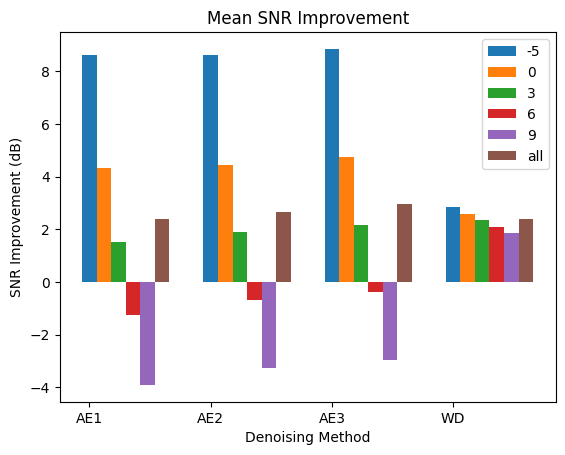

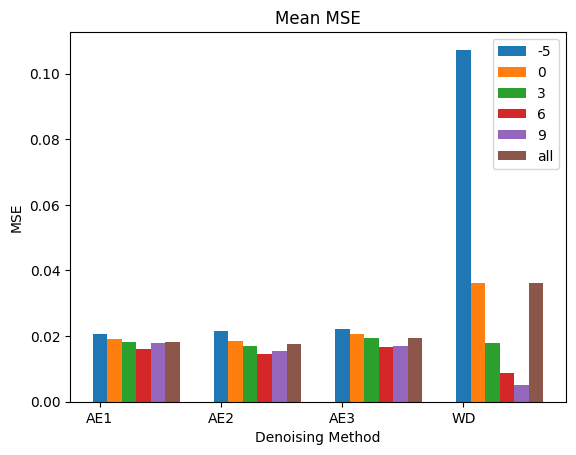

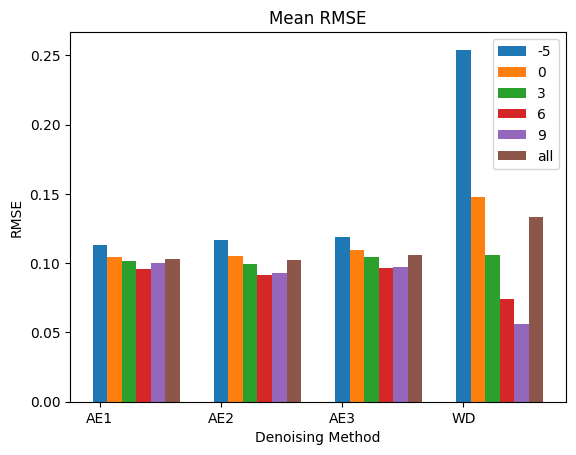

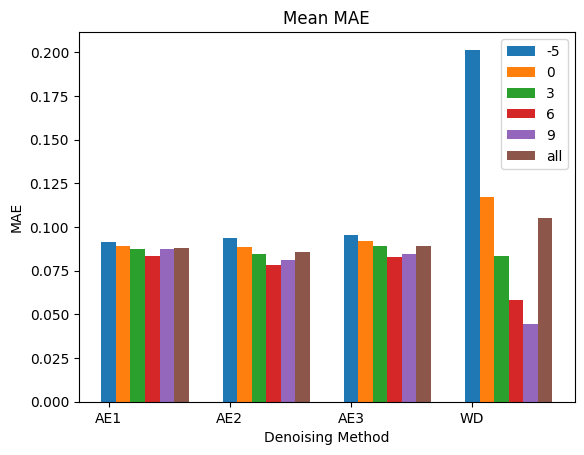

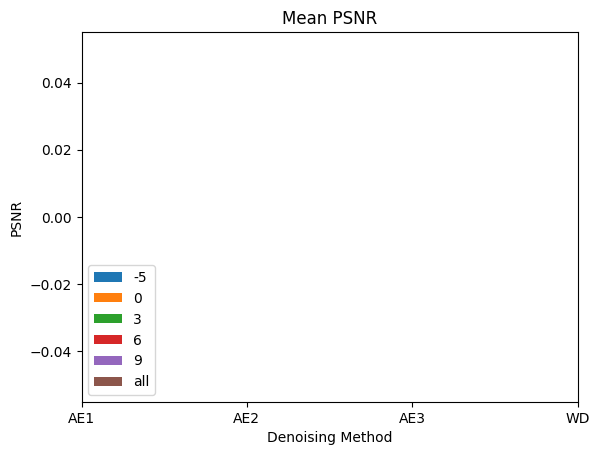

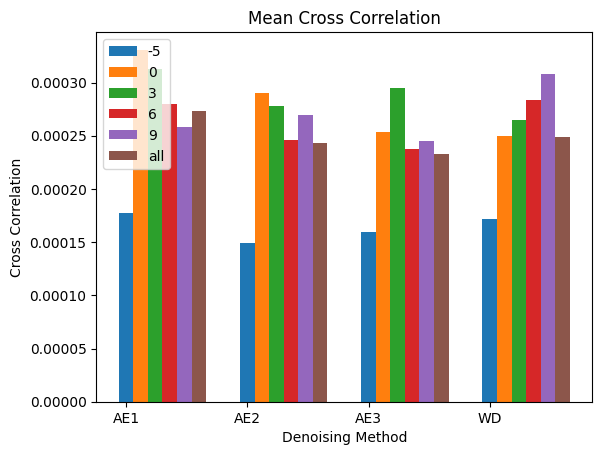

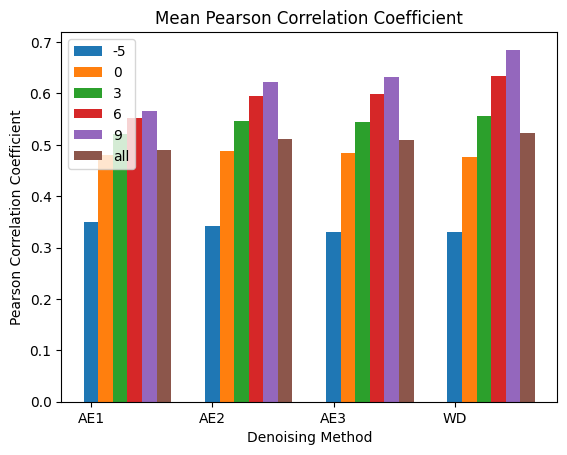

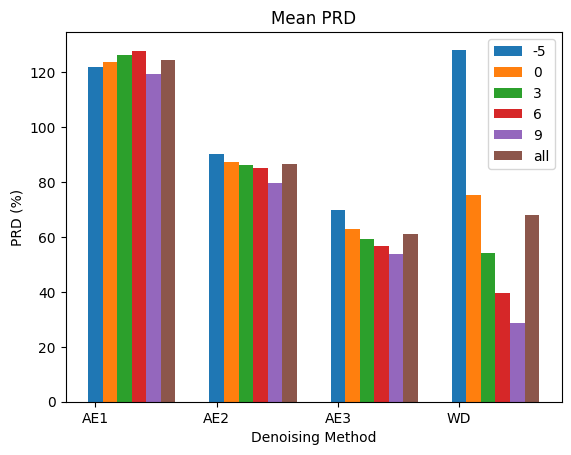

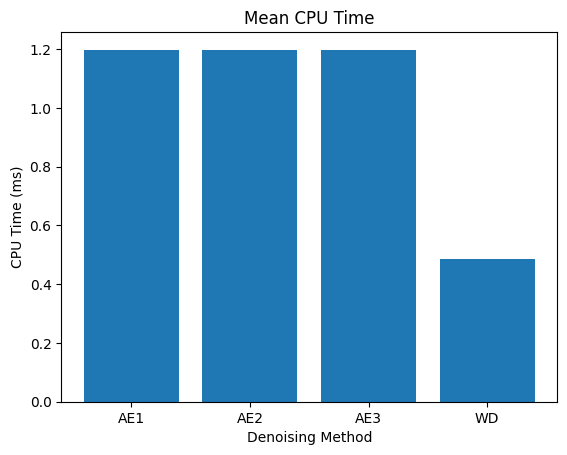

: 

: 

In [ ]:
# The config describes, which parameters should be tested.
config0 = {
    'methods': ['AE2', 'AE2', 'AE2', 'AE2'], #, 'WD']# , 'AE1+WD']
    'models': ['new/model_2.pth', 'old/normal_full/model_2_1024_relu_extended_10_3.pth', 'old/normal_full/model_2_1024_relu_extended_10_3.pth', 'old/normal_full/model_2_1024_relu_extended_20.pth'],
    'labels': ['Training Data', 'Results', 'Training Data + Results', 'No Usage'],
    'target_snr_print': [-1, 0, 1, 3, 8], # [-1, 0, 0.5, 1, 3, 5, 8]
    'bandpass': True,
    'xlabel': 'Bandpass Filter Usage'
}

config1 = {
    'methods': ['AE2', 'AE2', 'AE2', 'AE2'], #, 'WD']# , 'AE1+WD']
    'models': ['normal_full/model_2_1024_relu_simple.pth', 'normal_full/model_2_1024_relu_extended_5.pth', 'normal_full/model_2_1024_relu_extended_10_3.pth', 'normal_full/model_2_1024_relu_extended_20.pth'],
    'labels': ['1', '2', '3', '4'],
    'target_snr_print': [-1, 0, 1, 3, 8], # [-1, 0, 0.5, 1, 3, 5, 8]
    'bandpass': False,
    'xlabel': 'Noise Distribution'
}

config2 = {
    'methods': ['AE2', 'AE2', 'AE2', 'WD'],
    'models': ['new/normal/m2_128_simple.pth', 'new/normal/m2_128_10.pth', 'new/normal/m2_128_20.pth'],
    'labels': ['AE1', 'AE2', 'AE3', 'WD'],
    'target_snr_print': [-5, 0, 3, 6, 9], # [-5, -1, 0, 3, 6, 9]
    'bandpass': False,
    'xlabel': 'Denoising Method'
}

config3 = {
    'methods': ['AE2', 'AE2', 'AE2'],
    'models': ['model_2.pth', 'old/normal_full/model_1_1024_relu_extended_10.pth', 'old/normal_full/model_2_1024_relu_extended_10.pth', 'old/normal_full/model_2_1024_relu_extended_20.pth'],
    'labels': ['AE1', 'AE2', 'WD'],
    'target_snr_print': [-1, 0, 1, 3, 8], # [-1, 0, 0.5, 1, 3, 5, 8]
    'bandpass': False,
    'xlabel': 'Denoising Method'
}

# 10 --> old, 10_3 --> newest
results = test(config2)
save_results('./results/0/', results, config2)

14492
0.046914805
0.009513371

0.16848084
0.072588526

8.937772512435913
7.283496260643005
10.676801204681396

11.09054684638977
18.02030086517334

0.9191565090572567
0.9532501201841556



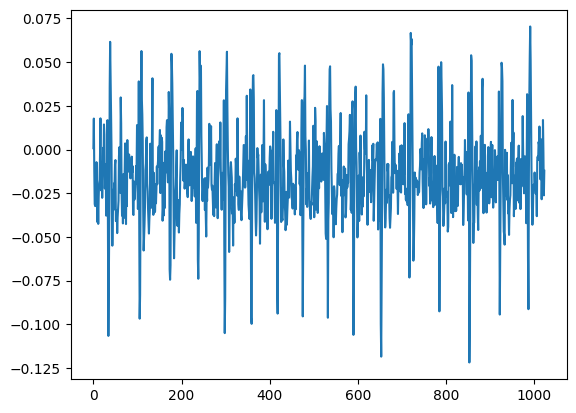

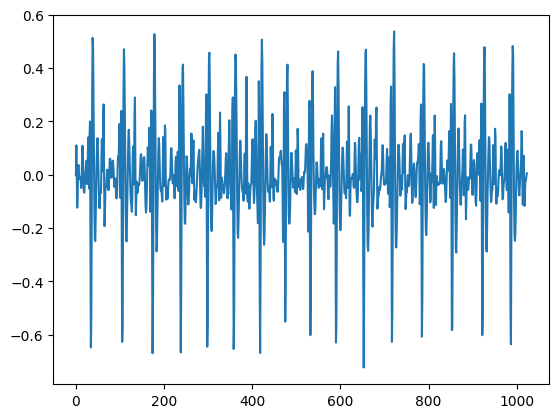

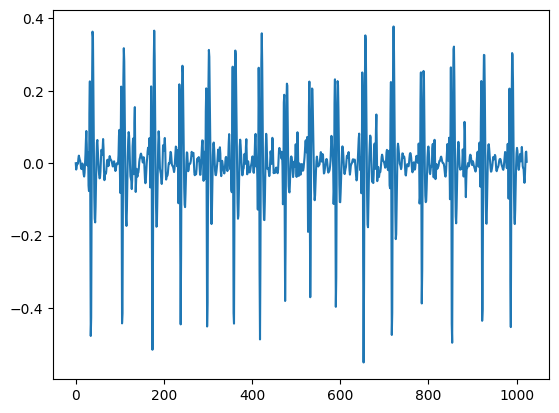

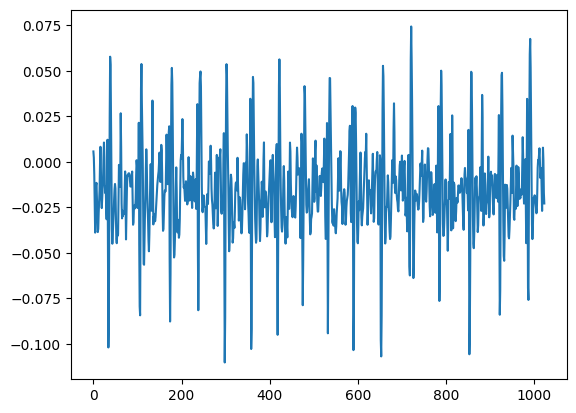

: 

: 

In [ ]:
model = DeNoise2(layer_size=256).to(device)
model.load_state_dict(torch.load(os.path.join(model_directory, 'new/normal/m2_128_20.pth')))

model.eval()

with torch.no_grad():
    
    i = random.choice(range(0, len(test_dataset)))
    print(i)

    noise = test_dataset[i][0]
    clean = test_dataset[i][1]

    clean = clean.reshape(-1, 1, window_size).to(device, dtype=torch.float)
    noise = noise.reshape(-1, 1, window_size).to(device, dtype=torch.float)

    predicted = model(noise).to('cpu').reshape(window_size).numpy()
    clean = clean.to('cpu').reshape(window_size).numpy()
    noise = noise.to('cpu').reshape(window_size).numpy()
    predicted2 = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')

    noise_snr = denormalize(noise, test_dataset.dataset.min_val, test_dataset.dataset.max_val)
    predicted_snr = denormalize(predicted, test_dataset.dataset.min_val, test_dataset.dataset.max_val)
    predicted2_snr = denormalize(predicted2, test_dataset.dataset.min_val, test_dataset.dataset.max_val)

    print(mse(clean, noise))
    print(mse(clean, predicted))
    print()

    print(mae(clean, noise))
    print(mae(clean, predicted))
    print()

    print(snr(clean, noise_snr))
    print(snr(clean, predicted))
    print(snr(clean, predicted2_snr))
    print()

    print(psnr(clean, noise))
    print(psnr(clean, predicted))
    print()

    print(pcorr(clean, noise))
    print(pcorr(bandpass(clean), bandpass(predicted)))
    print()
    
    time_from = 0
    time_to = 1024

    plt.plot(range(time_to)[time_from:time_to], noise[time_from:time_to])
    plt.show()
    plt.plot(range(time_to)[time_from:time_to], bandpass(clean)[time_from:time_to])
    plt.show()
    plt.plot(range(time_to)[time_from:time_to], bandpass(predicted)[time_from:time_to])
    plt.show()
    plt.plot(range(time_to)[time_from:time_to], predicted2[time_from:time_to])
    plt.show()

    torch.cuda.empty_cache()